In [46]:
import numpy as np
import matplotlib.pyplot as plt

In [47]:
def generate_curve(start=0, end=10, increment=0.1, lower_band=1, upper_band=5, max_amplitude=2):
    """
    Generate a set of points representing a band-limited curve that passes through (0,0).
    
    Args:
    start (float): Start of the domain (default: 0)
    end (float): End of the domain (default: 10)
    increment (float): Step size between points (default: 0.1)
    lower_band (float): Lower frequency band limit in Hz (default: 1)
    upper_band (float): Upper frequency band limit in Hz (default: 5)
    max_amplitude (float): Maximum amplitude of the curve (default: 2)
    
    Returns:
    tuple: Two arrays (x, y) representing the points of the curve
    """
    x = np.arange(start, end + increment, increment)
    y = np.zeros_like(x)
    
    # Generate random frequencies within the band limits
    num_frequencies = np.random.randint(3, 10)
    frequencies = np.random.uniform(lower_band, upper_band, num_frequencies)
    
    # Generate random amplitudes for each frequency component
    amplitudes = np.random.uniform(0.1, 1, num_frequencies)
    
    # Use cosine instead of sine to ensure y(0) = 0
    for freq, amp in zip(frequencies, amplitudes):
        y += amp * (np.cos(2 * np.pi * freq * x) - 1)
    
    # Normalize the curve to the desired maximum amplitude
    y_max = np.max(np.abs(y))
    if y_max > 0:
        y *= (max_amplitude / y_max)
    
    return x, y

In [48]:
def plot_curve(x, y, title="Band-Limited Curve"):
    """
    Plot the generated curve.
    
    Args:
    x (array): x-coordinates of the curve
    y (array): y-coordinates of the curve
    title (str): Title of the plot (default: "Band-Limited Curve")
    """
    plt.figure(figsize=(12, 6))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()


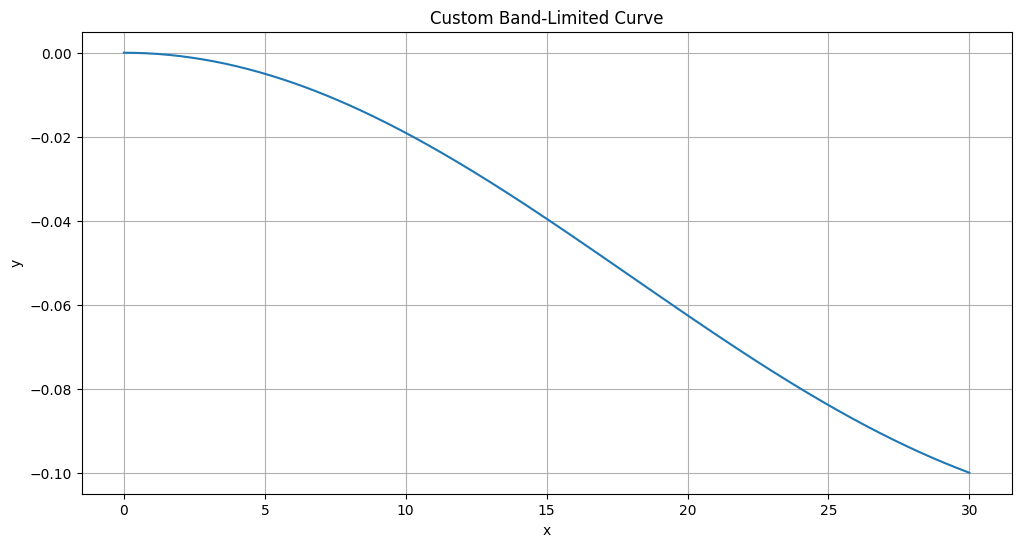

In [49]:

# Specifying custom parameters including max amplitude
x, y = generate_curve(start=0, end=30, increment=0.1, lower_band=0, upper_band=1/60, max_amplitude=0.1)


plot_curve(x, y, title="Custom Band-Limited Curve")

In [50]:
import numpy as np
from scipy import interpolate

def curve_tangents(x, y, n):
    """
    Calculate tangents at n points along a curve defined by x and y coordinates.
    
    Args:
    x (array): x-coordinates of the curve
    y (array): y-coordinates of the curve
    n (int): Number of points to sample
    
    Returns:
    tuple: Two arrays (sample_x, tangents) where sample_x are the x positions
           and tangents are the slopes at those positions
    """
    # Create a function to interpolate the curve
    f = interpolate.interp1d(x, y, kind='linear', bounds_error=False, fill_value='extrapolate')
    
    # Create sample points
    sample_x = np.linspace(x[0], x[-1], n)
    
    # Calculate tangents using central difference method
    h = (x[-1] - x[0]) / (len(x) * 1000)  # Adaptive step size
    
    # Use forward difference for the first point, backward difference for the last point
    tangents = np.zeros(n)
    tangents[1:-1] = (f(sample_x[1:-1] + h) - f(sample_x[1:-1] - h)) / (2 * h)
    tangents[0] = (f(sample_x[0] + h) - f(sample_x[0])) / h
    tangents[-1] = (f(sample_x[-1]) - f(sample_x[-1] - h)) / h
    
    return sample_x, tangents




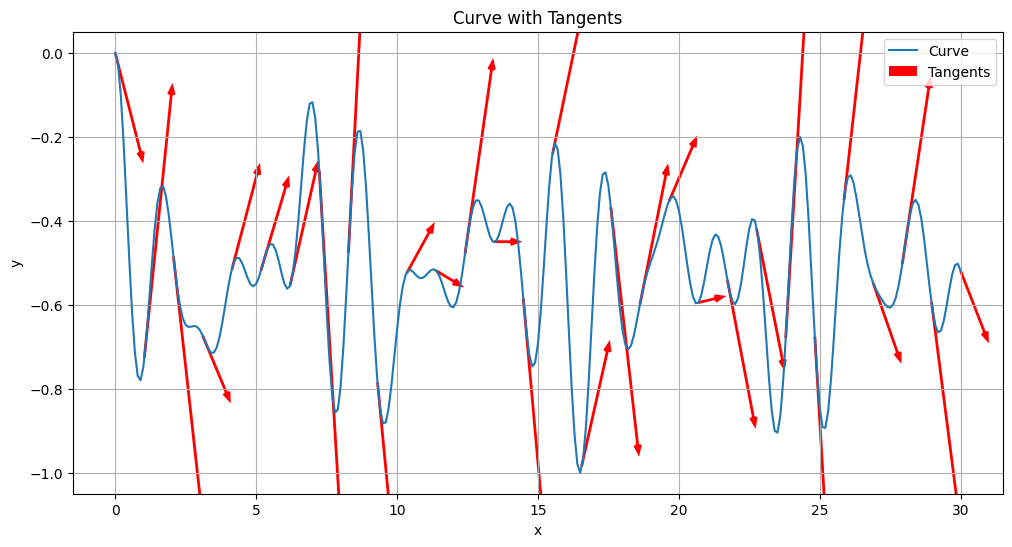

In [51]:
# Example usage:
x, y = generate_curve(start=0, end=30, increment=0.1, lower_band=0, upper_band=1, max_amplitude=1)
sample_x, tangents = curve_tangents(x, y, 30)

# Create interpolation function for plotting
f = interpolate.interp1d(x, y, kind='linear', bounds_error=False, fill_value='extrapolate')

plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Curve')
plt.quiver(sample_x, f(sample_x), np.ones_like(sample_x), tangents, 
           angles='xy', scale_units='xy', scale=1, color='r', width=0.003, 
           headwidth=3, headlength=4, label='Tangents')
plt.legend()
plt.title('Curve with Tangents')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [52]:
from scipy.interpolate import CubicSpline

def regenerate_curve_spline(x, t):
    """
    Reconstruct curve using cubic spline interpolation of the tangents.
    """
    if x[0] != 0:
        x = np.concatenate(([0], x))
        t = np.concatenate(([0], t))
    
    # Integrate tangents using spline
    cs = CubicSpline(x, t)
    y = np.array([cs.antiderivative()(xi) for xi in x])
    return x, y

In [53]:
from numpy.polynomial import Polynomial

def regenerate_curve_poly(x, t):
    """
    Reconstruct curve using polynomial fitting of the tangents.
    """
    if x[0] != 0:
        x = np.concatenate(([0], x))
        t = np.concatenate(([0], t))
    
    # Fit polynomial to tangents
    degree = min(len(x) - 1, 10)  # Limit degree to prevent overfitting
    p = Polynomial.fit(x, t, degree)
    
    # Integrate polynomial
    p_int = p.integ()
    y = p_int(x)
    return x, y

In [54]:
import numpy as np
from scipy.integrate import cumtrapz

def regenerate_curve(x, t):
    """
    Reconstruct a curve from x positions and tangents, assuming y(0) = 0.
    
    Args:
    x (array): x-coordinates
    t (array): tangents at corresponding x-coordinates
    
    Returns:
    tuple: Two arrays (x, y) representing the reconstructed curve
    """
    # Ensure x starts from 0
    if x[0] != 0:
        x = np.concatenate(([0], x))
        t = np.concatenate(([0], t))  # Assume tangent at x=0 is 0
    
    # Integrate tangents to get y values
    y = cumtrapz(t, x, initial=0)
    
    return x, y

In [55]:
from scipy.integrate import cumulative_trapezoid

def regenerate_curve_richardson(x, t):
    """
    Reconstruct curve using trapezoidal rule with Richardson extrapolation.
    """
    if x[0] != 0:
        x = np.concatenate(([0], x))
        t = np.concatenate(([0], t))
    
    # First integration with normal step size
    y1 = cumulative_trapezoid(t, x, initial=0)
    
    # Second integration with half step size
    x_half = np.interp(np.linspace(x[0], x[-1], 2*len(x)-1), x, x)
    t_half = np.interp(x_half, x, t)
    y2 = cumulative_trapezoid(t_half, x_half, initial=0)[::2]
    
    # Richardson extrapolation
    y = (4*y2 - y1) / 3
    return x, y

In [56]:
def rk4_step(x, y, h, t_func):
    k1 = t_func(x, y)
    k2 = t_func(x + h/2, y + h*k1/2)
    k3 = t_func(x + h/2, y + h*k2/2)
    k4 = t_func(x + h, y + h*k3)
    return y + h*(k1 + 2*k2 + 2*k3 + k4)/6

def regenerate_curve_rk4(x, t):
    """
    Reconstruct curve using 4th order Runge-Kutta integration.
    """
    if x[0] != 0:
        x = np.concatenate(([0], x))
        t = np.concatenate(([0], t))
    
    # Create interpolation function for tangents
    t_func = interpolate.interp1d(x, t, kind='cubic', fill_value='extrapolate')
    
    y = np.zeros_like(x)
    for i in range(1, len(x)):
        h = x[i] - x[i-1]
        y[i] = rk4_step(x[i-1], y[i-1], h, t_func)
    
    return x, y

C:\Users\Daniel\AppData\Local\Temp\ipykernel_28448\4106159034.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  y = cumtrapz(t, x, initial=0)


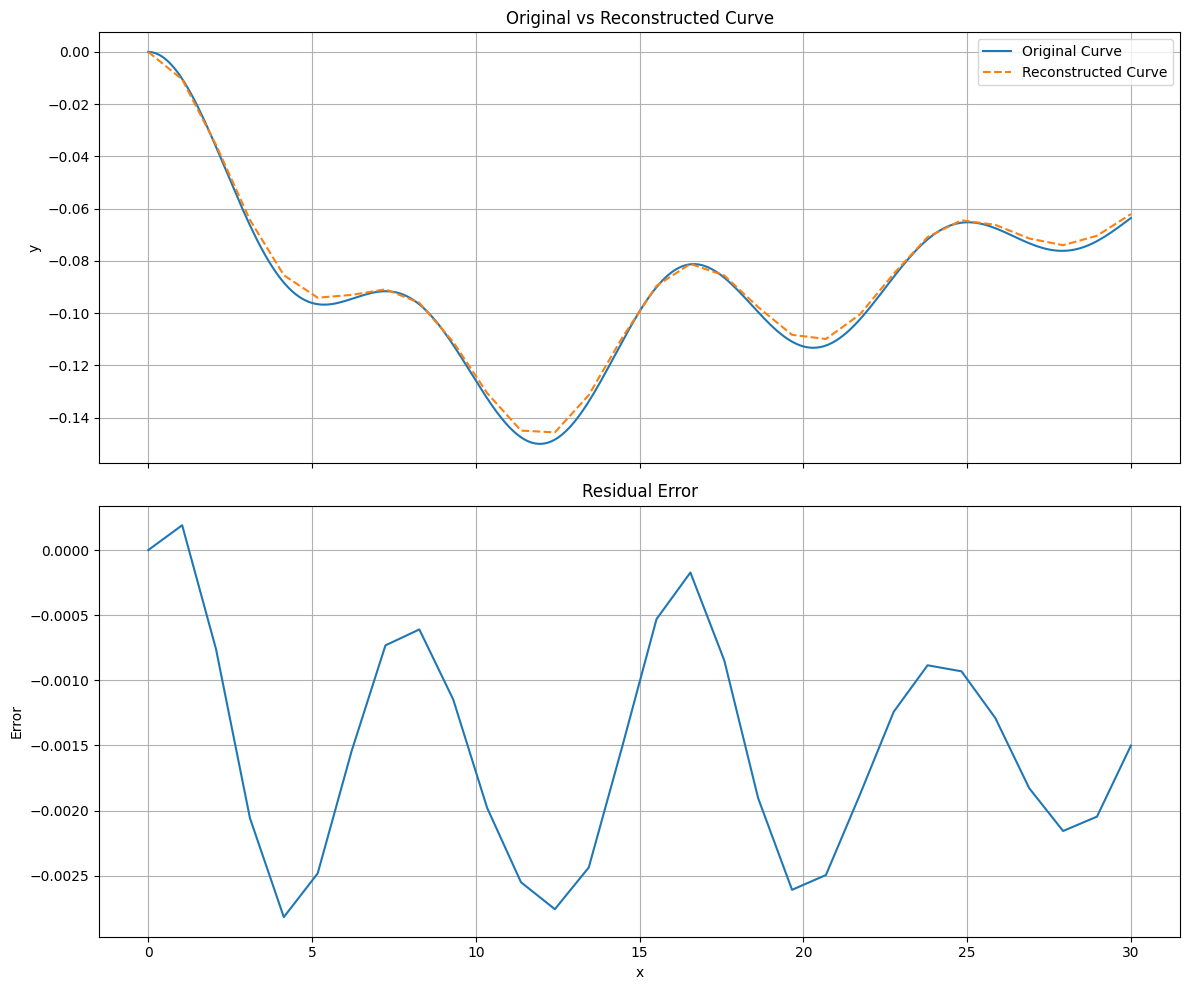

Maximum absolute error: 0.002818
Mean absolute error: 0.001529
Root mean square error: 0.001734


In [57]:
borehole_length = 30
inflection_frequency = 4
deflection_max = 0.15
ots_nodes = 30

x, y = generate_curve(start=0, end=borehole_length, increment=0.1, lower_band=0, upper_band=inflection_frequency/borehole_length, max_amplitude=deflection_max)
sample_x, tangents = curve_tangents(x, y, ots_nodes)
reconstructed_x, reconstructed_y = regenerate_curve(sample_x, tangents)

# Create interpolation function for the original curve
f_original = interpolate.interp1d(x, y, kind='linear', bounds_error=False, fill_value='extrapolate')

# Calculate residual error
y_original_at_sample = f_original(reconstructed_x)
residual_error = y_original_at_sample - reconstructed_y

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot original and reconstructed curves
ax1.plot(x, y, label='Original Curve')
ax1.plot(reconstructed_x, reconstructed_y, '--', label='Reconstructed Curve')
ax1.legend()
ax1.set_title('Original vs Reconstructed Curve')
ax1.set_ylabel('y')
ax1.grid(True)

# Plot residual error
ax2.plot(reconstructed_x, residual_error)
ax2.set_title('Residual Error')
ax2.set_xlabel('x')
ax2.set_ylabel('Error')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print some statistics about the error
print(f"Maximum absolute error: {np.max(np.abs(residual_error)):.6f}")
print(f"Mean absolute error: {np.mean(np.abs(residual_error)):.6f}")
print(f"Root mean square error: {np.sqrt(np.mean(residual_error**2)):.6f}")

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy import interpolate
import ipywidgets as widgets
from IPython.display import display

# Assuming generate_curve, curve_tangents, and regenerate_curve functions are already defined

def update_plots(borehole_length, inflection_frequency, deflection_max, ots_nodes, method):
    x, y = generate_curve(start=0, end=borehole_length, increment=0.1, 
                         lower_band=0, upper_band=inflection_frequency/borehole_length, 
                         max_amplitude=deflection_max)
    sample_x, tangents = curve_tangents(x, y, ots_nodes)
    
    # Choose reconstruction method
    if method == 'Spline':
        reconstructed_x, reconstructed_y = regenerate_curve_spline(sample_x, tangents)
    elif method == 'Polynomial':
        reconstructed_x, reconstructed_y = regenerate_curve_poly(sample_x, tangents)
    elif method == 'Richardson':
        reconstructed_x, reconstructed_y = regenerate_curve_richardson(sample_x, tangents)
    elif method == 'RK4':
        reconstructed_x, reconstructed_y = regenerate_curve_rk4(sample_x, tangents)
    else:
        reconstructed_x, reconstructed_y = regenerate_curve(sample_x, tangents)

    f_original = interpolate.interp1d(x, y, kind='linear', bounds_error=False, fill_value='extrapolate')
    y_original_at_sample = f_original(reconstructed_x)
    residual_error = y_original_at_sample - reconstructed_y

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot original and reconstructed curves
    ax1.plot(x, y, label='Original Curve')
    ax1.plot(reconstructed_x, reconstructed_y, '--', label='Reconstructed Curve')
    
    # Plot tangent locations as points
    ax1.scatter(sample_x, f_original(sample_x), color='r', s=30, label='Tangent Points')
    
    ax1.legend()
    ax1.set_title('Original vs Reconstructed Curve (with Tangent Points)')
    ax1.set_ylabel('y')
    ax1.grid(True)

    # Plot residual error
    ax2.plot(reconstructed_x, residual_error)
    ax2.set_title('Residual Error')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Error')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    max_error = np.max(np.abs(residual_error))
    mean_error = np.mean(np.abs(residual_error))
    rms_error = np.sqrt(np.mean(residual_error**2))

    print(f"Maximum absolute error: {max_error:.6f}")
    print(f"Mean absolute error: {mean_error:.6f}")
    print(f"Root mean square error: {rms_error:.6f}")

# Create widgets
borehole_length_slider = widgets.FloatSlider(value=30, min=5, max=50, step=1, description='Borehole Length (m):')
inflection_frequency_slider = widgets.FloatSlider(value=4, min=0, max=8, step=0.1, description='Inflection Frequency:')
deflection_max_slider = widgets.FloatSlider(value=0.15, min=0.01, max=1, step=0.01, description='Max Deflection (m):')
ots_nodes_slider = widgets.IntSlider(value=30, min=1, max=100, step=1, description='OTS Nodes:')

method_dropdown = widgets.Dropdown(
    options=['Trapezoid', 'Spline', 'Polynomial', 'Richardson', 'RK4'],
    value='Trapezoid',
    description='Method:'
)

# Create interactive output
interactive_plot = widgets.interactive(update_plots, 
    borehole_length=borehole_length_slider,
    inflection_frequency=inflection_frequency_slider,
    deflection_max=deflection_max_slider,
    ots_nodes=ots_nodes_slider,
    method=method_dropdown
)
# Display the interactive widget
display(interactive_plot)

interactive(children=(FloatSlider(value=30.0, description='Borehole Length (m):', max=50.0, min=5.0, step=1.0)…